# 1. Dependencies

Point at the project we will work on

In [44]:
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objects as go
import requests
import seaborn as sns

from google.colab import drive
from os import sep
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Link this notebook with Google Colab

In [45]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
%cd 'drive/MyDrive/HACKEPS 2024/'

[Errno 2] No such file or directory: 'drive/MyDrive/HACKEPS 2024/'
/content/drive/MyDrive/HACKEPS 2024


In [47]:
%ls

modelo_afluencia.pkl  parking_afluencia_final.csv


## 2.2. General Functions

In [48]:
TRUE_CONDITIONS = ['y', 'yes']

def handle_requests_response(response, store_path, check_save=False, df_name=''):
    print('> Found', len(response.content.decode('utf-8').split('\n')), 'lines aprox., proceed to store them?')
    df_name = df_name + '.csv' if '.csv' not in df_name else df_name
    store_csv = input('\tYes(Y)/No(N): ')

    if store_csv.lower() in TRUE_CONDITIONS:
        print('\t> Response to CSV....')
        fname = store_path + df_name
        csv_file = open(fname, 'wb')
        csv_file.write(response.content)
        csv_file.close()
        check_save and print('\t> Is CSV file ready?', os.path.isfile(fname))

In [49]:
prepare_path = lambda path: not os.path.exists(path) and os.makedirs(path)

# 4. Data Loading
Load the different Datasets involved in your problem framing as pd.DataFrame() using the `pd.read_csv()` function.

In [50]:
parking_afluencia_final = pd.read_csv('parking_afluencia_final.csv')
print(parking_afluencia_final.head())
parking_afluencia_final = pd.read_csv('parking_afluencia_final.csv', index_col=0)

                             parking_id  afluencia             datetime
0  217fa335-bcb3-4aca-8f17-c0fc62dcb8fa         10  2024-11-16 21:00:00
1  217fa335-bcb3-4aca-8f17-c0fc62dcb8fa         20  2024-11-16 22:00:00
2  217fa335-bcb3-4aca-8f17-c0fc62dcb8fa         21  2024-11-16 23:00:00
3  217fa335-bcb3-4aca-8f17-c0fc62dcb8fa         15  2024-11-17 00:00:00
4  217fa335-bcb3-4aca-8f17-c0fc62dcb8fa         13  2024-11-17 01:00:00


# 5. Data Preliminary Inspection
> A recommended _go-though_ is to start with basic toolkit functions such as `.head()`, `.info()` or `.describe()` to detect _easy-to-spot_ conflicts.

In [51]:
parking_afluencia_final

,afluencia,datetime
parking_id,,
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,10,2024-11-16 21:00:00
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,20,2024-11-16 22:00:00
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,21,2024-11-16 23:00:00
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,15,2024-11-17 00:00:00
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,13,2024-11-17 01:00:00
...,...,...
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,44,2024-11-23 17:00:00
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,23,2024-11-23 18:00:00
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,24,2024-11-23 19:00:00


In [52]:
parking_afluencia_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169 entries, 217fa335-bcb3-4aca-8f17-c0fc62dcb8fa to 217fa335-bcb3-4aca-8f17-c0fc62dcb8fa
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   afluencia  169 non-null    int64 
 1   datetime   169 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


In [53]:
parking_afluencia_final.describe()

,afluencia
count,169.000000
mean,34.426036
std,18.746956
min,10.000000
25%,21.000000
50%,30.000000
75%,43.000000
max,70.000000


# 6. Data Manipulation

In [54]:
parking_afluencia_final["datetime"] = pd.to_datetime(parking_afluencia_final["datetime"])
parking_afluencia_final["day"] = parking_afluencia_final["datetime"].dt.day_name()
parking_afluencia_final["hour"] = parking_afluencia_final["datetime"].dt.hour

In [55]:
parking_afluencia_final

,afluencia,datetime,day,hour
parking_id,,,,
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,10,2024-11-16 21:00:00,Saturday,21
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,20,2024-11-16 22:00:00,Saturday,22
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,21,2024-11-16 23:00:00,Saturday,23
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,15,2024-11-17 00:00:00,Sunday,0
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,13,2024-11-17 01:00:00,Sunday,1
...,...,...,...,...
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,44,2024-11-23 17:00:00,Saturday,17
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,23,2024-11-23 18:00:00,Saturday,18
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,24,2024-11-23 19:00:00,Saturday,19


In [56]:
label_encoder = LabelEncoder()
parking_afluencia_final["day"] = label_encoder.fit_transform(parking_afluencia_final["day"])

In [57]:
parking_afluencia_final

,afluencia,datetime,day,hour
parking_id,,,,
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,10,2024-11-16 21:00:00,2,21
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,20,2024-11-16 22:00:00,2,22
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,21,2024-11-16 23:00:00,2,23
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,15,2024-11-17 00:00:00,3,0
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,13,2024-11-17 01:00:00,3,1
...,...,...,...,...
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,44,2024-11-23 17:00:00,2,17
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,23,2024-11-23 18:00:00,2,18
217fa335-bcb3-4aca-8f17-c0fc62dcb8fa,24,2024-11-23 19:00:00,2,19


# Modeling - Regression




In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [59]:
X = parking_afluencia_final[["hour", "day"]]  # Usamos hora, día y día de la semana
y = parking_afluencia_final["afluencia"]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [62]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Mean Absolute Error: 6.393789215686274
Mean Squared Error: 74.72350744199346


#Testing model

In [63]:
y_all_pred = model.predict(X)

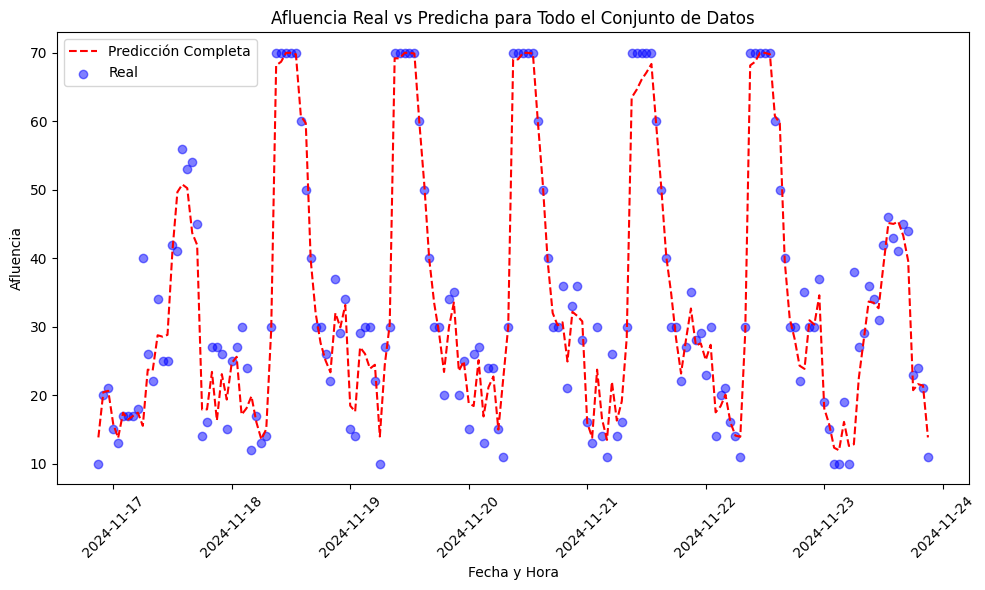

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(parking_afluencia_final["datetime"], y_all_pred, label='Predicción Completa', color='red', linestyle='--')  # Predicción
plt.scatter(parking_afluencia_final["datetime"], parking_afluencia_final["afluencia"], label='Real', color='blue', alpha=0.5)  # Datos reales
plt.title('Afluencia Real vs Predicha para Todo el Conjunto de Datos')
plt.xlabel('Fecha y Hora')
plt.ylabel('Afluencia')
plt.legend()
plt.xticks(rotation=45)  # Rotar etiquetas del eje X para mejorar la legibilidad
plt.tight_layout()
plt.show()

#Download model

In [65]:
joblib.dump(model, 'modelo_afluencia.pkl')

['modelo_afluencia.pkl']